In [118]:
# !pip install -q -U category_encoders
library = ['category_encoders','pyampute']
for i in library:
  !pip install -q -U {i}

#EDA

A. Data Quality
1.   Bagaimana jenis missing values yang ada?
2.   Bagaimana outliers-nya?
3.   Bagaimana jumlah datanya dan potensi yang ada?

B. Pertanyaan Fitur "Price" (Target Label):
1.   Distribusi variabel pada setiap fitur bagaimana?
2.   Apakah terdapat outlier di fitur "price"?
3.   Bagaimana korelasi setiap fitur terhadap fitur "price"?

Representasi korelasi:
*   **0.9 ≤	r	≤ 1.0**	Korelasi sangat kuat
*   **0.7 ≤	r	< 0.9**	Korelasi kuat
*   **0.5 ≤	r	< 0.7**	Korelasi moderat (cukup kuat)
*   **0.3 ≤	r	< 0.5**	Korelasi lemah
*   **0.0 ≤	r	< 0.3**	Korelasi sangat lemah/tidak ada

C. Pertanyaan Fitur Numerik:
1.   Ada multikolinearitas antara fitur numerik?


D. Pertanyaan Tentang Fitur Kategorikal
1.   Tipe mobil apa (SUV, sedan, dll) yang punya harga tertinggi?
2.   Bagaimana rata-rata dari setiap merk mobil?
3.   Bagaimana pengaruh num of doors, body style, engine size, dan compression ratio ke harga?




##Import Library

In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import category_encoders as ce
import random
import numpy as np
import tensorflow as tf

from category_encoders import BinaryEncoder
from pyampute.exploration.mcar_statistical_tests import MCARTest
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from sklearn.metrics import r2_score
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

pd.options.mode.chained_assignment = None
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

###Data Loading and Overview

In [120]:
df = pd.read_csv('https://drive.google.com/uc?id=1wBk7BZA6nykXwtN0ArA6-qz7ulxlbKa_',na_values=['?'])

In [121]:
df.head(3)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0


###Data Dimention and Structure

In [122]:
print(df.shape)
print(df.info())
display(df.describe())

(205, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       203 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size     

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.000000,164.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,201.000000,201.000000,205.000000,203.000000,203.000000,205.000000,205.000000,201.000000
mean,0.834146,122.000000,98.756585,174.049268,65.907805,53.724878,2555.565854,126.907317,3.329751,3.255423,10.142537,104.256158,5125.369458,25.219512,30.751220,13207.129353
std,1.245307,35.442168,6.021776,12.337289,2.145204,2.443522,520.680204,41.642693,0.273539,0.316717,3.972040,39.714369,479.334560,6.542142,6.886443,7947.066342
min,-2.000000,65.000000,86.600000,141.100000,60.300000,47.800000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,13.000000,16.000000,5118.000000
25%,0.000000,94.000000,94.500000,166.300000,64.100000,52.000000,2145.000000,97.000000,3.150000,3.110000,8.600000,70.000000,4800.000000,19.000000,25.000000,7775.000000
50%,1.000000,115.000000,97.000000,173.200000,65.500000,54.100000,2414.000000,120.000000,3.310000,3.290000,9.000000,95.000000,5200.000000,24.000000,30.000000,10295.000000
75%,2.000000,150.000000,102.400000,183.100000,66.900000,55.500000,2935.000000,141.000000,3.590000,3.410000,9.400000,116.000000,5500.000000,30.000000,34.000000,16500.000000
max,3.000000,256.000000,120.900000,208.100000,72.300000,59.800000,4066.000000,326.000000,3.940000,4.170000,23.000000,288.000000,6600.000000,49.000000,54.000000,45400.000000


###Missing Values and Duplicated

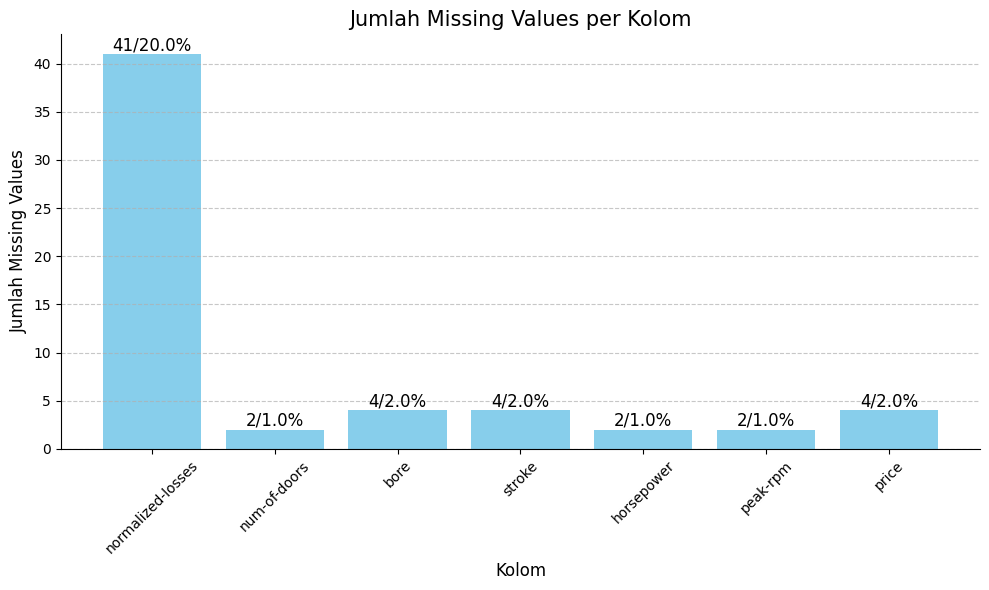

In [123]:
missing_count = df.isnull().sum()
missing_percent = df.isnull().mean() * 100
missing_data = missing_count[missing_count > 0].to_frame(name='count')
missing_data['percent'] = missing_percent[missing_percent > 0]

plt.figure(figsize=(10, 6))
bars = plt.bar(missing_data.index, missing_data['count'], color='skyblue')

for bar, pct in zip(bars, missing_data['percent']):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}/{pct:.1f}%', ha='center', va='bottom', fontsize=12)

plt.title('Jumlah Missing Values per Kolom', fontsize=15)
plt.xlabel('Kolom', fontsize=12)
plt.ylabel('Jumlah Missing Values', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine()
plt.tight_layout()
plt.show()

In [124]:
# Display missing value each in columns
pd.set_option('display.max_columns', None)

for col in df.columns:
    if df[col].isnull().any():
        print(f"\nBaris yang memiliki missing values pada kolom: '{col}'")
        display(df[df[col].isnull()])


Baris yang memiliki missing values pada kolom: 'normalized-losses'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
5,2,NaN,audi,gas,std,two,sedan,fwd,front,99.8,177.3,66.3,53.1,2507,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,15250.0
7,1,NaN,audi,gas,std,four,wagon,fwd,front,105.8,192.7,71.4,55.7,2954,ohc,five,136,mpfi,3.19,3.40,8.5,110.0,5500.0,19,25,18920.0
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN
14,1,NaN,bmw,gas,std,four,sedan,rwd,front,103.5,189.0,66.9,55.7,3055,ohc,six,164,mpfi,3.31,3.19,9.0,121.0,4250.0,20,25,24565.0
15,0,NaN,bmw,gas,std,four,sedan,rwd,front,103.5,189.0,66.9,55.7,3230,ohc,six,209,mpfi,3.62,3.39,8.0,182.0,5400.0,16,22,30760.0
16,0,NaN,bmw,gas,std,two,sedan,rwd,front,103.5,193.8,67.9,53.7,3380,ohc,six,209,mpfi,3.62,3.39,8.0,182.0,5400.0,16,22,41315.0
17,0,NaN,bmw,gas,std,four,sedan,rwd,front,110.0,197.0,70.9,56.3,3505,ohc,six,209,mpfi,3.62,3.39,8.0,182.0,5400.0,15,20,36880.0



Baris yang memiliki missing values pada kolom: 'num-of-doors'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
27,1,148.0,dodge,gas,turbo,NaN,sedan,fwd,front,93.7,157.3,63.8,50.6,2191,ohc,four,98,mpfi,3.03,3.39,7.6,102.0,5500.0,24,30,8558.0
63,0,NaN,mazda,diesel,std,NaN,sedan,fwd,front,98.8,177.8,66.5,55.5,2443,ohc,four,122,idi,3.39,3.39,22.7,64.0,4650.0,36,42,10795.0



Baris yang memiliki missing values pada kolom: 'bore'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
55,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,10945.0
56,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,11845.0
57,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2385,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,13645.0
58,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2500,rotor,two,80,mpfi,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0



Baris yang memiliki missing values pada kolom: 'stroke'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
55,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,10945.0
56,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2380,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,11845.0
57,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2385,rotor,two,70,4bbl,NaN,NaN,9.4,101.0,6000.0,17,23,13645.0
58,3,150.0,mazda,gas,std,two,hatchback,rwd,front,95.3,169.0,65.7,49.6,2500,rotor,two,80,mpfi,NaN,NaN,9.4,135.0,6000.0,16,23,15645.0



Baris yang memiliki missing values pada kolom: 'horsepower'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
130,0,NaN,renault,gas,std,four,wagon,fwd,front,96.1,181.5,66.5,55.2,2579,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9295.0
131,2,NaN,renault,gas,std,two,hatchback,fwd,front,96.1,176.8,66.6,50.5,2460,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9895.0



Baris yang memiliki missing values pada kolom: 'peak-rpm'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
130,0,NaN,renault,gas,std,four,wagon,fwd,front,96.1,181.5,66.5,55.2,2579,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9295.0
131,2,NaN,renault,gas,std,two,hatchback,fwd,front,96.1,176.8,66.6,50.5,2460,ohc,four,132,mpfi,3.46,3.9,8.7,NaN,NaN,23,31,9895.0



Baris yang memiliki missing values pada kolom: 'price'


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight,engine-type,num-of-cylinders,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN
44,1,NaN,isuzu,gas,std,two,sedan,fwd,front,94.5,155.9,63.6,52.0,1874,ohc,four,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
45,0,NaN,isuzu,gas,std,four,sedan,fwd,front,94.5,155.9,63.6,52.0,1909,ohc,four,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
129,1,NaN,porsche,gas,std,two,hatchback,rwd,front,98.4,175.7,72.3,50.5,3366,dohcv,eight,203,mpfi,3.94,3.11,10.0,288.0,5750.0,17,28,NaN


<Axes: >

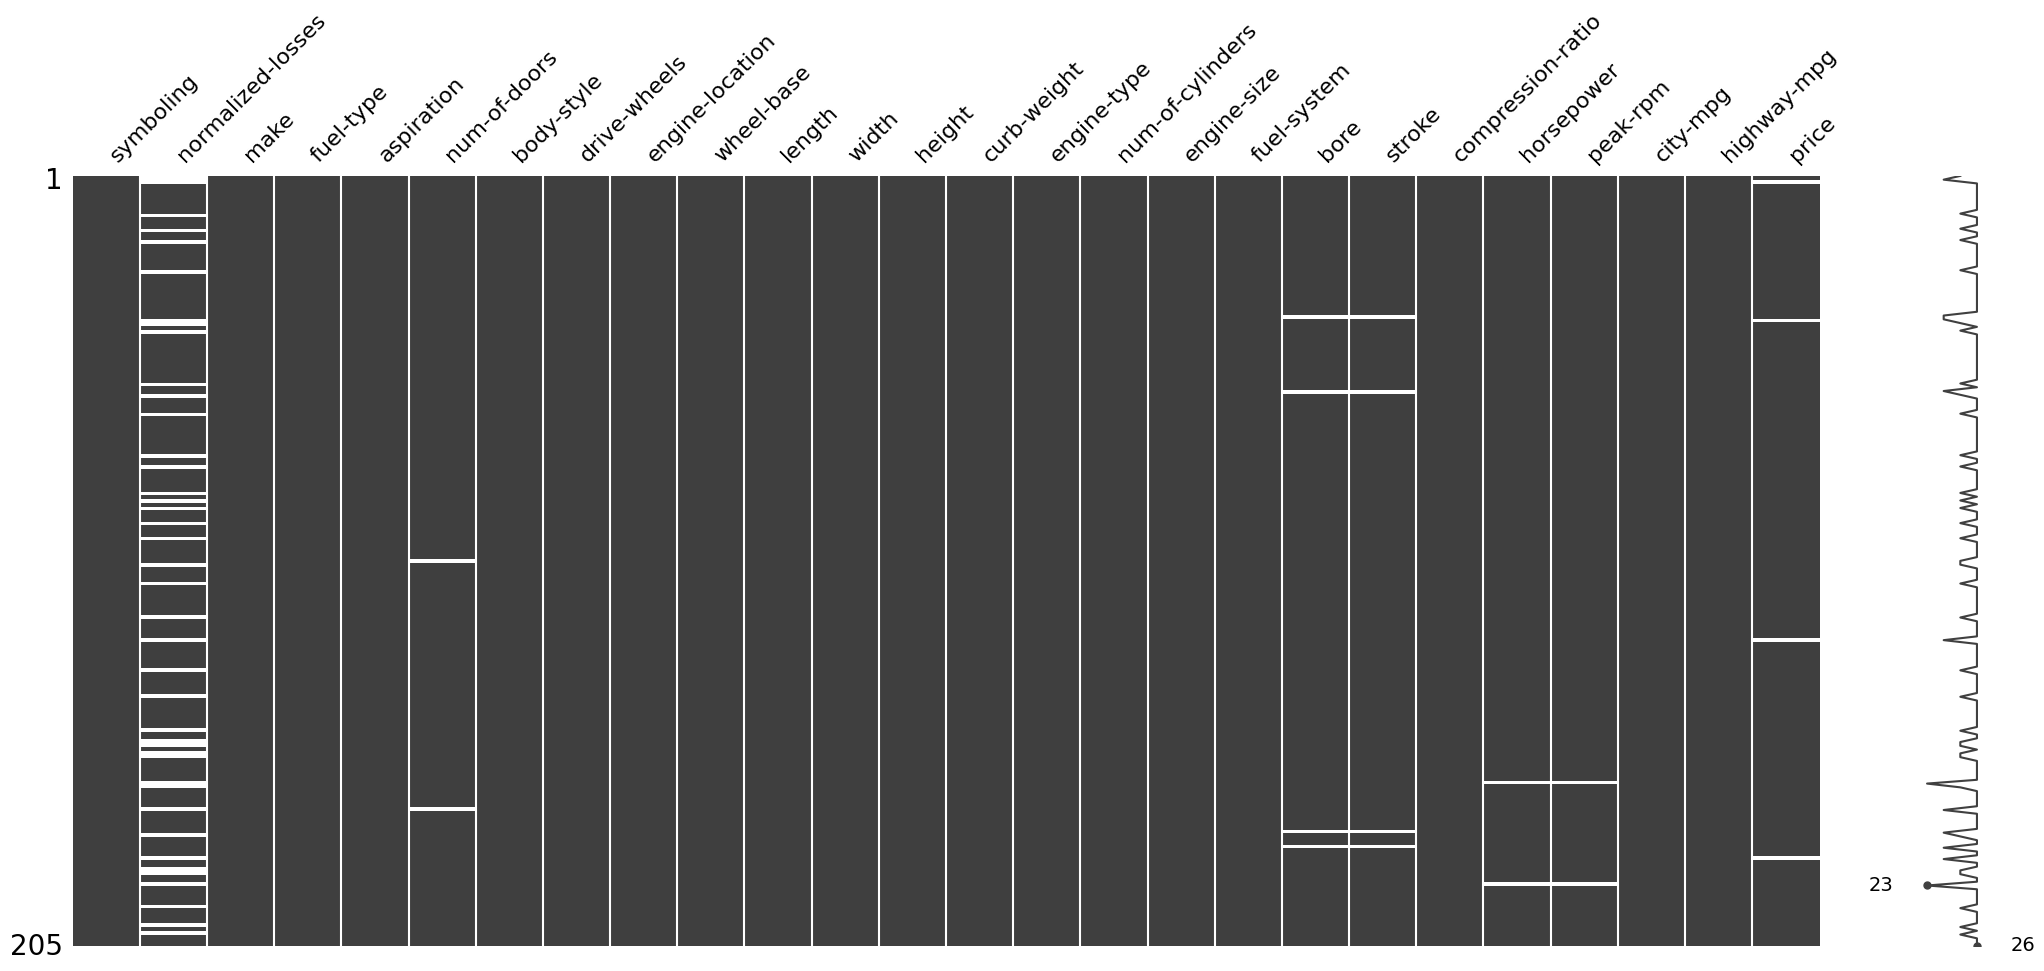

In [125]:
# Missing values use missingno
msno.matrix(df.sample(n=205))

<Axes: >

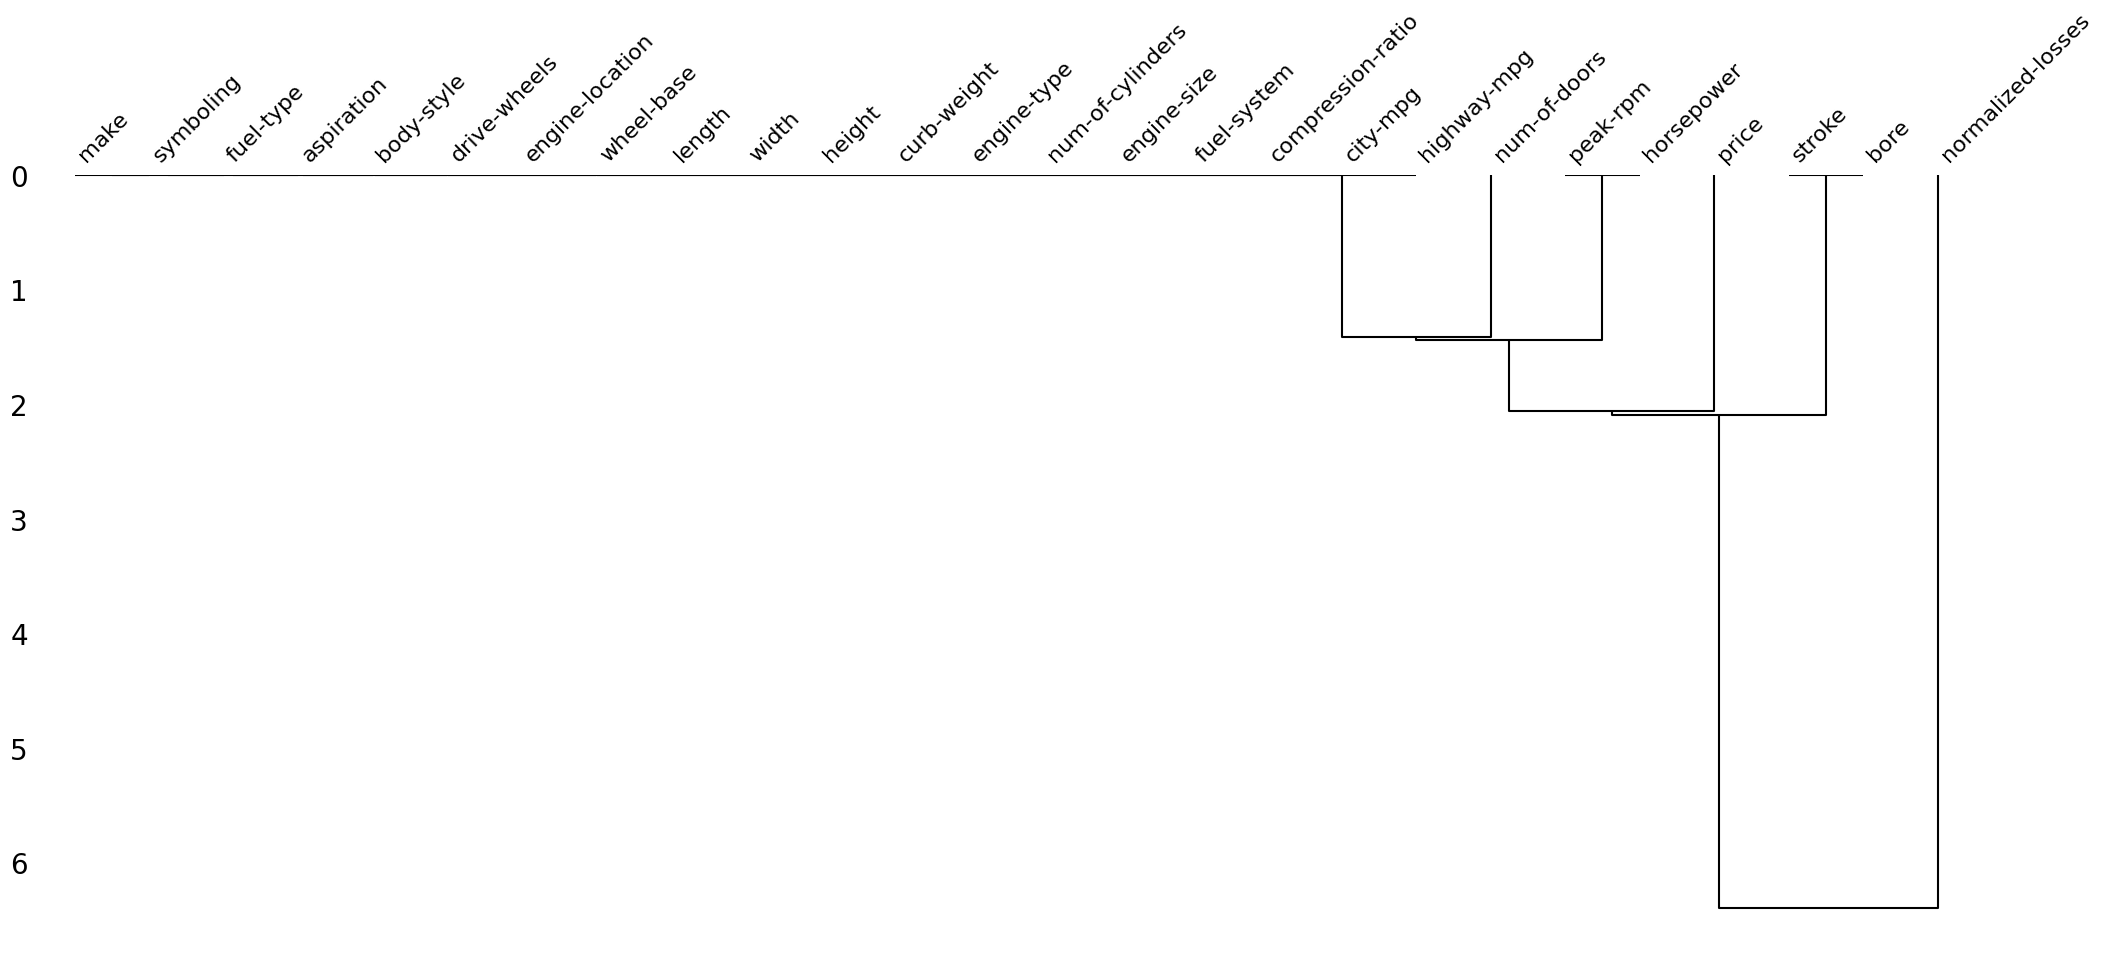

In [126]:
msno.dendrogram(df)

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


<Axes: >

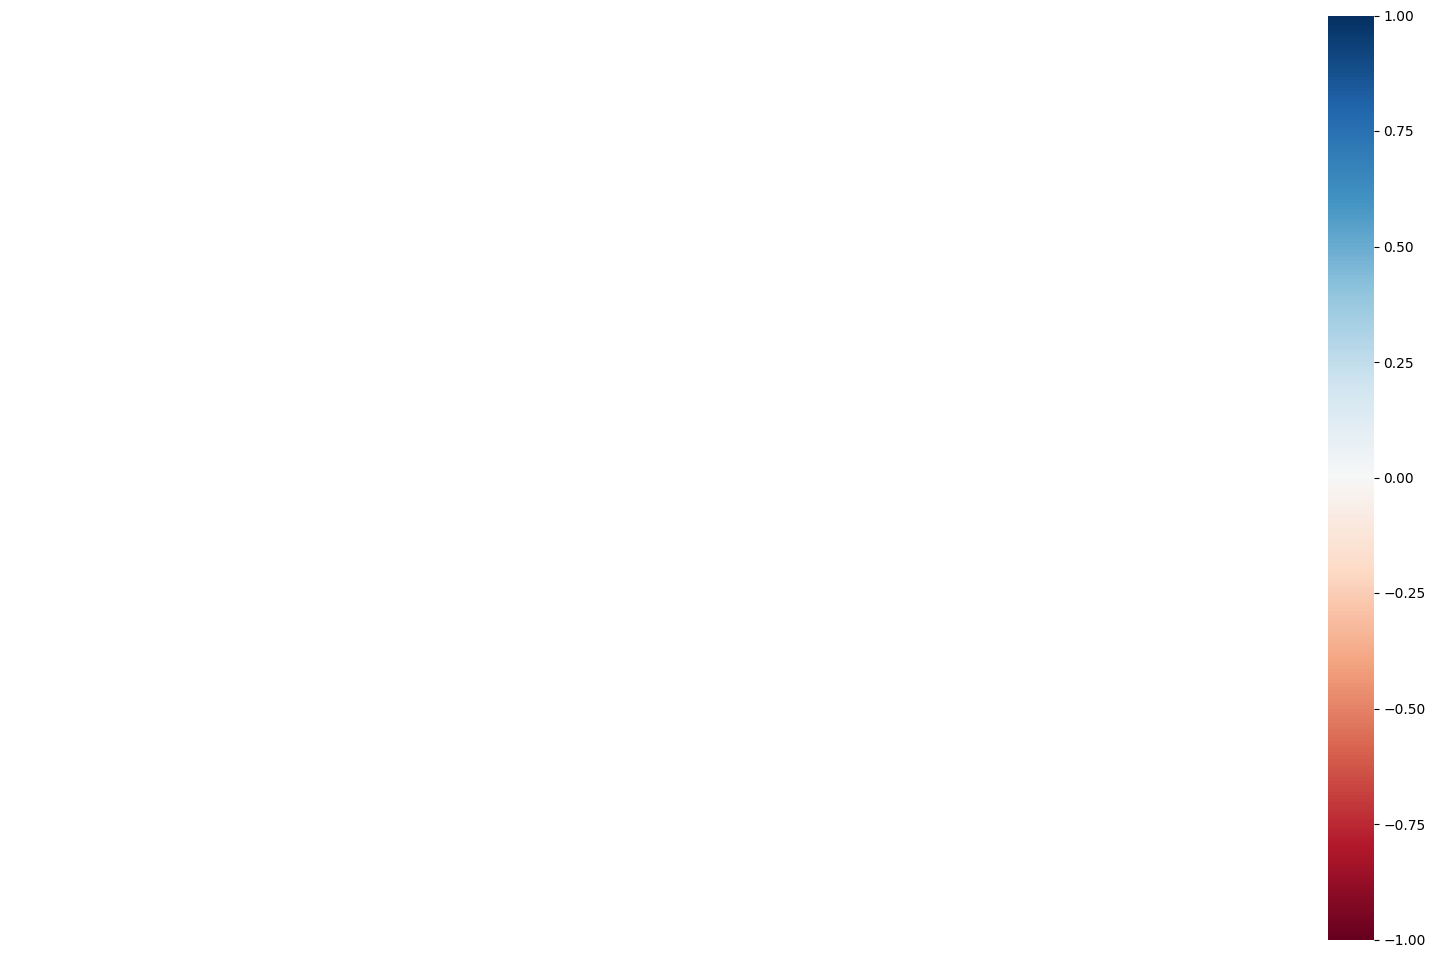

In [127]:
msno.heatmap(data)

<Axes: >

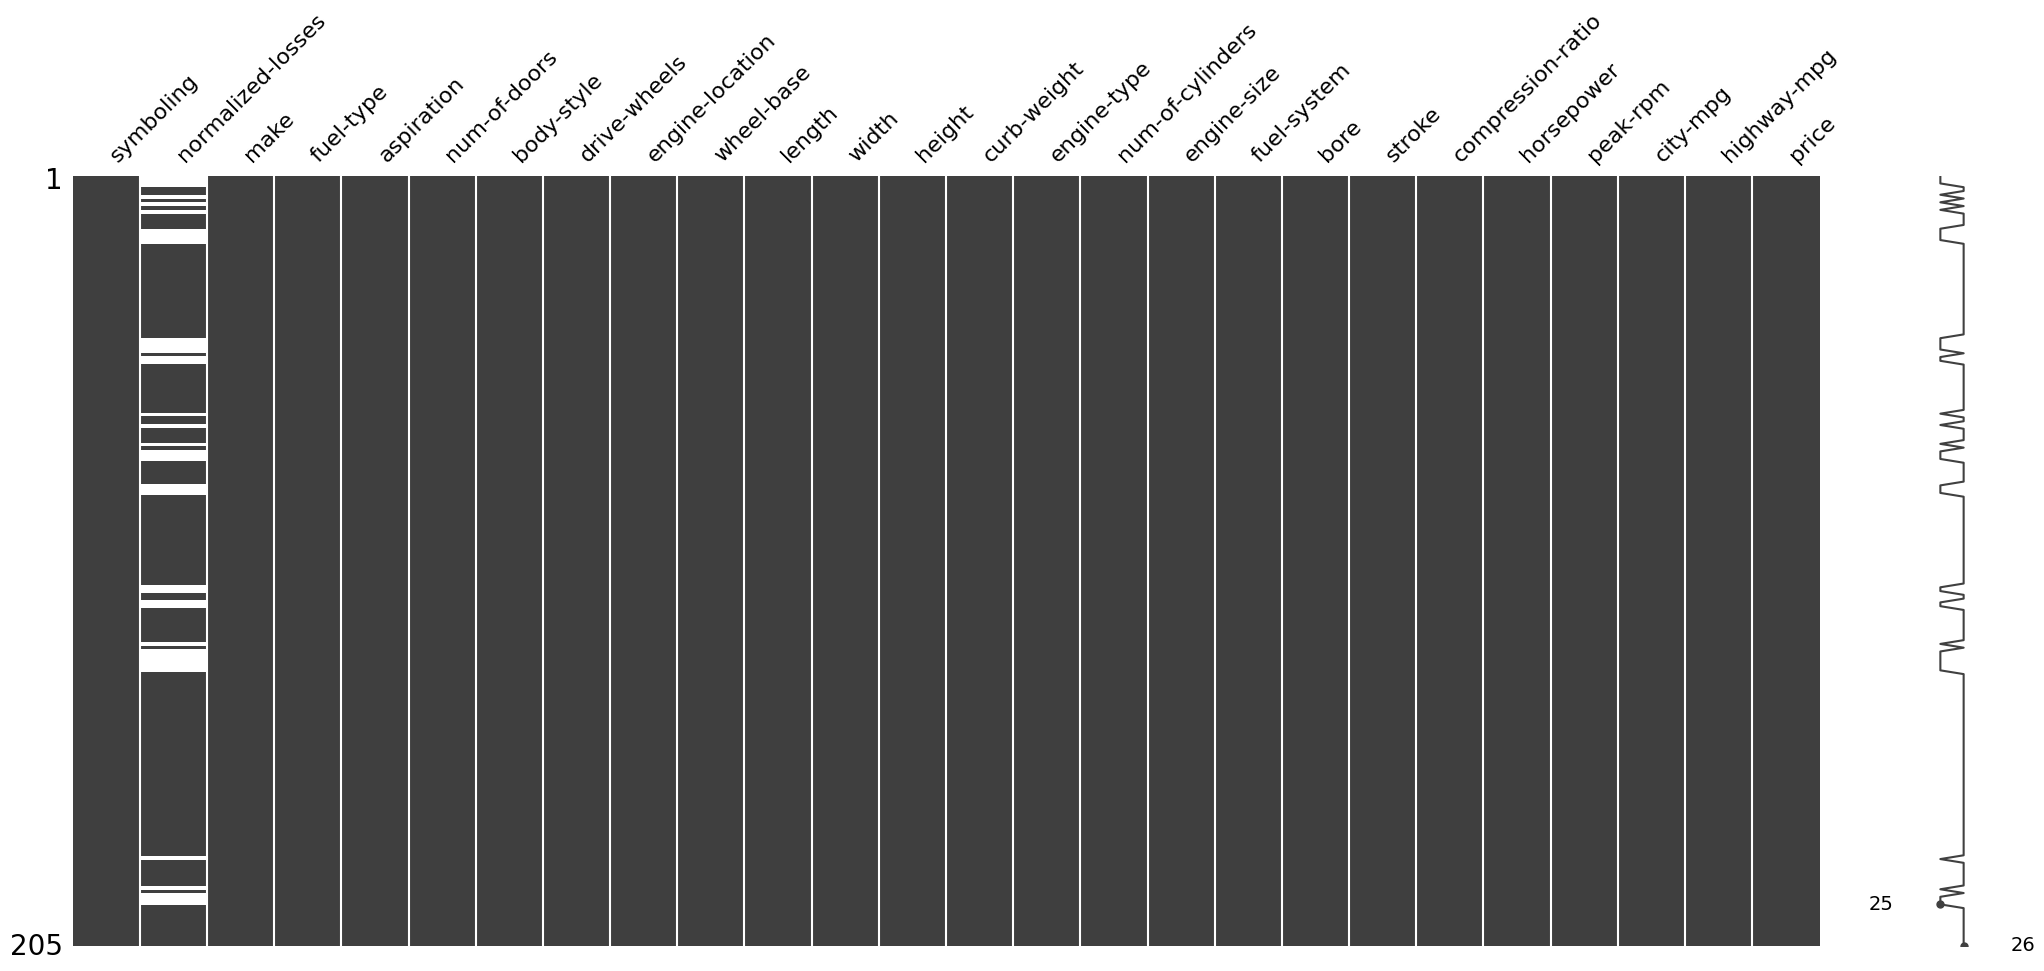

In [128]:
# Handle missing values by mean
data = df.select_dtypes(include=['int64','float64'])
handle_missingvalues = [col for col in data.columns if col not in ['normalized-losses']]

for col in handle_missingvalues:
    mean_value = data[col].mean()
    df[col] = df[col].fillna(mean_value)

for asp in df['aspiration'].dropna().unique():
    mode_doors = df.loc[df['aspiration'] == asp, 'num-of-doors'].mode()
    if not mode_doors.empty:
        df.loc[(df['aspiration'] == asp) & (df['num-of-doors'].isna()), 'num-of-doors'] = mode_doors[0]

msno.matrix(df)

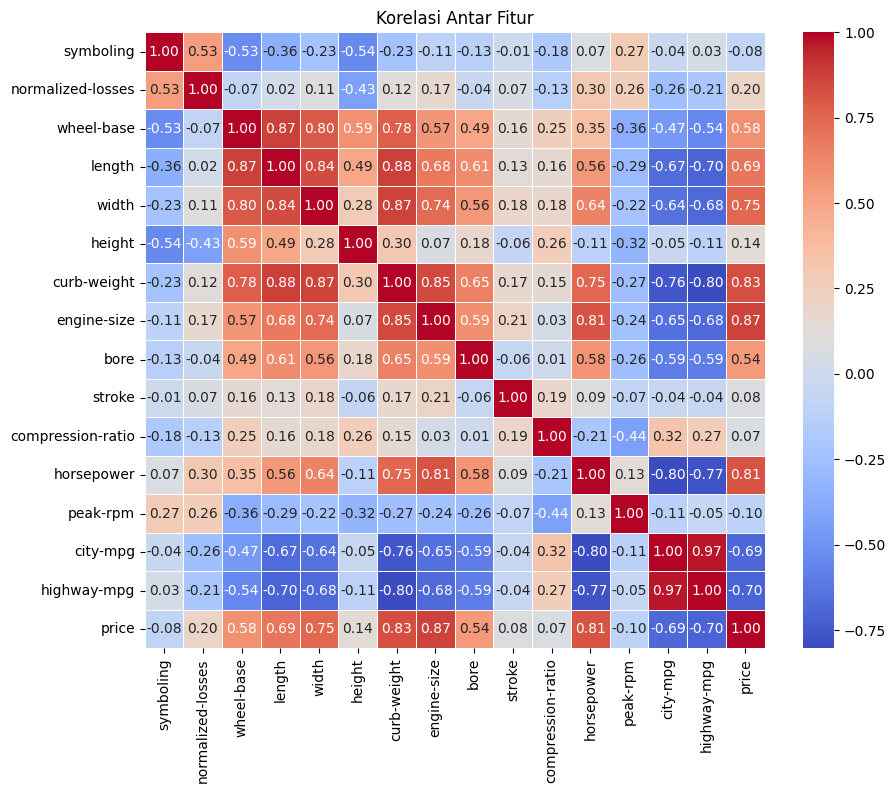

In [129]:
# Handle missing values in "normalized-lossess" because it has up to 20%
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasi Antar Fitur')
plt.show()

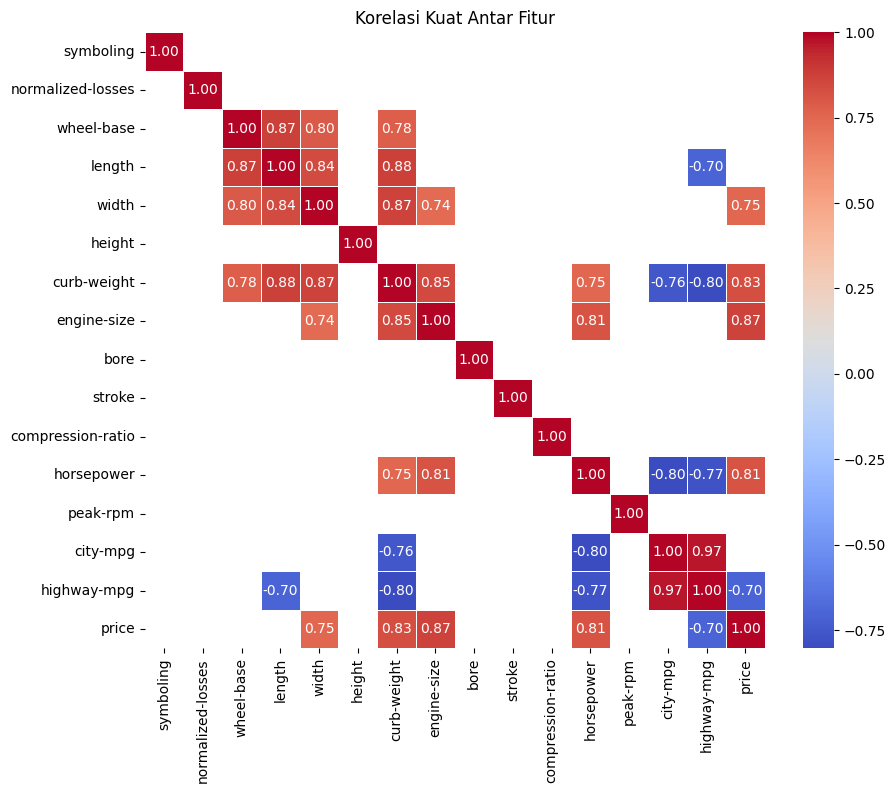

In [130]:
threshold = 0.7

strong_correlations = correlation_matrix[abs(correlation_matrix) > threshold]
strong_correlations = strong_correlations.dropna(axis=1, how='all').dropna(axis=0, how='all')

plt.figure(figsize=(10, 8))
sns.heatmap(strong_correlations, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasi Kuat Antar Fitur')
plt.show()

<Axes: >

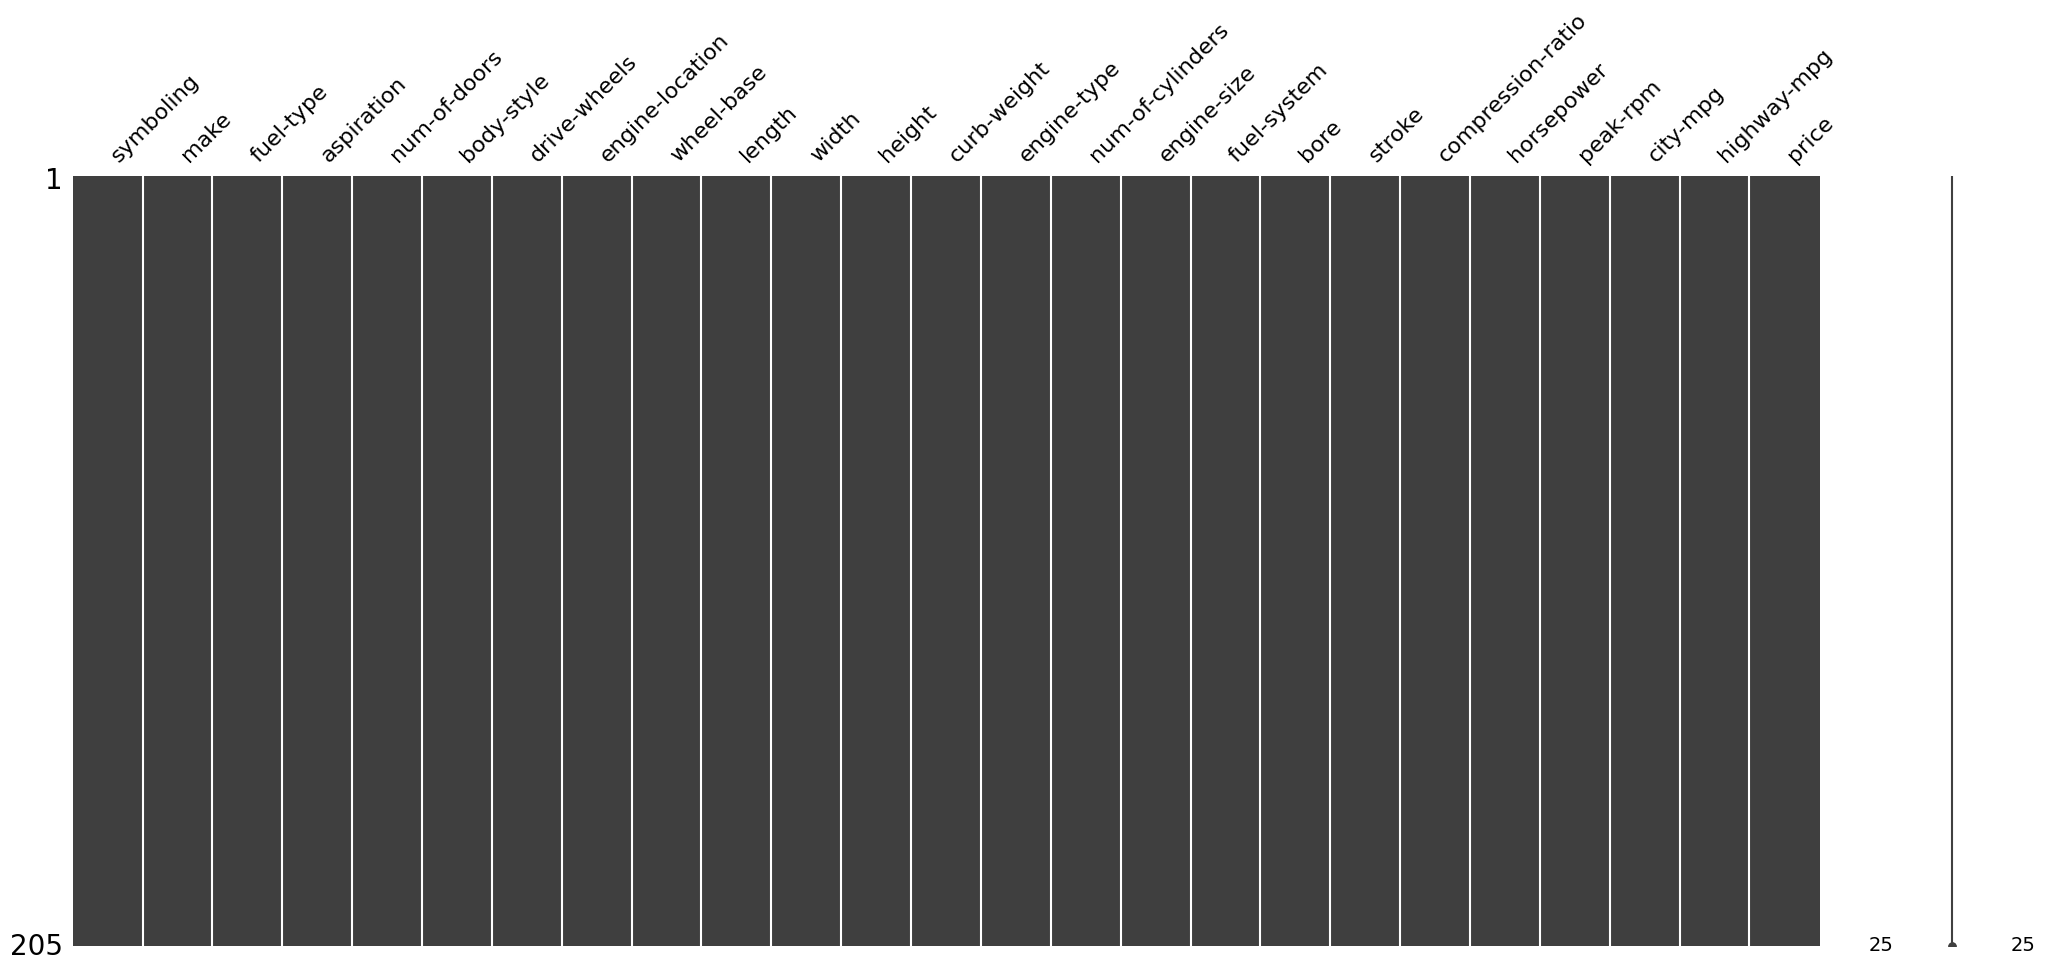

In [131]:
df.drop('normalized-losses', axis=1, inplace=True)
data = df.select_dtypes(include=['int64','float64'])
msno.matrix(df)

In [132]:
print(f'Data duplicated: {df.duplicated().sum()}')

Data duplicated: 0


Berdasarkan analisis terhadap missing values, didapatkan bahwa:
1.   Maks missing values setiap baris adalah 3 fitur
2.   'Normalized-losses' mempunyai kekuatan hubungan missing values yang cukup rendah (tidak kuat) setiap baris (data) terhadap fiturnya
3.   Selain itu, normalized-losses memiliki jumlah missing values sebesar 20%, dibanding fitur lainnya yang di 4%

Oleh karena itu, dilakukan imputasi cukup menggunakan mean pada data numerik dengan missing values < 5%, selain itu untuk data kategori menggunakan modus. Berbeda dengan 'normalized-losses' yang diputuskan untuk dihapus berdasarkan pertimbangan:
1.   memiliki hubungan missing values dengan fitur lain yang tergolong tidak terlalu kuat
2.   Hubungan antar fitur terutama terhadap fitur 'price' tidak kuat
3.   Jumlah missing values yang terlalu banyak



###Distribution of Data

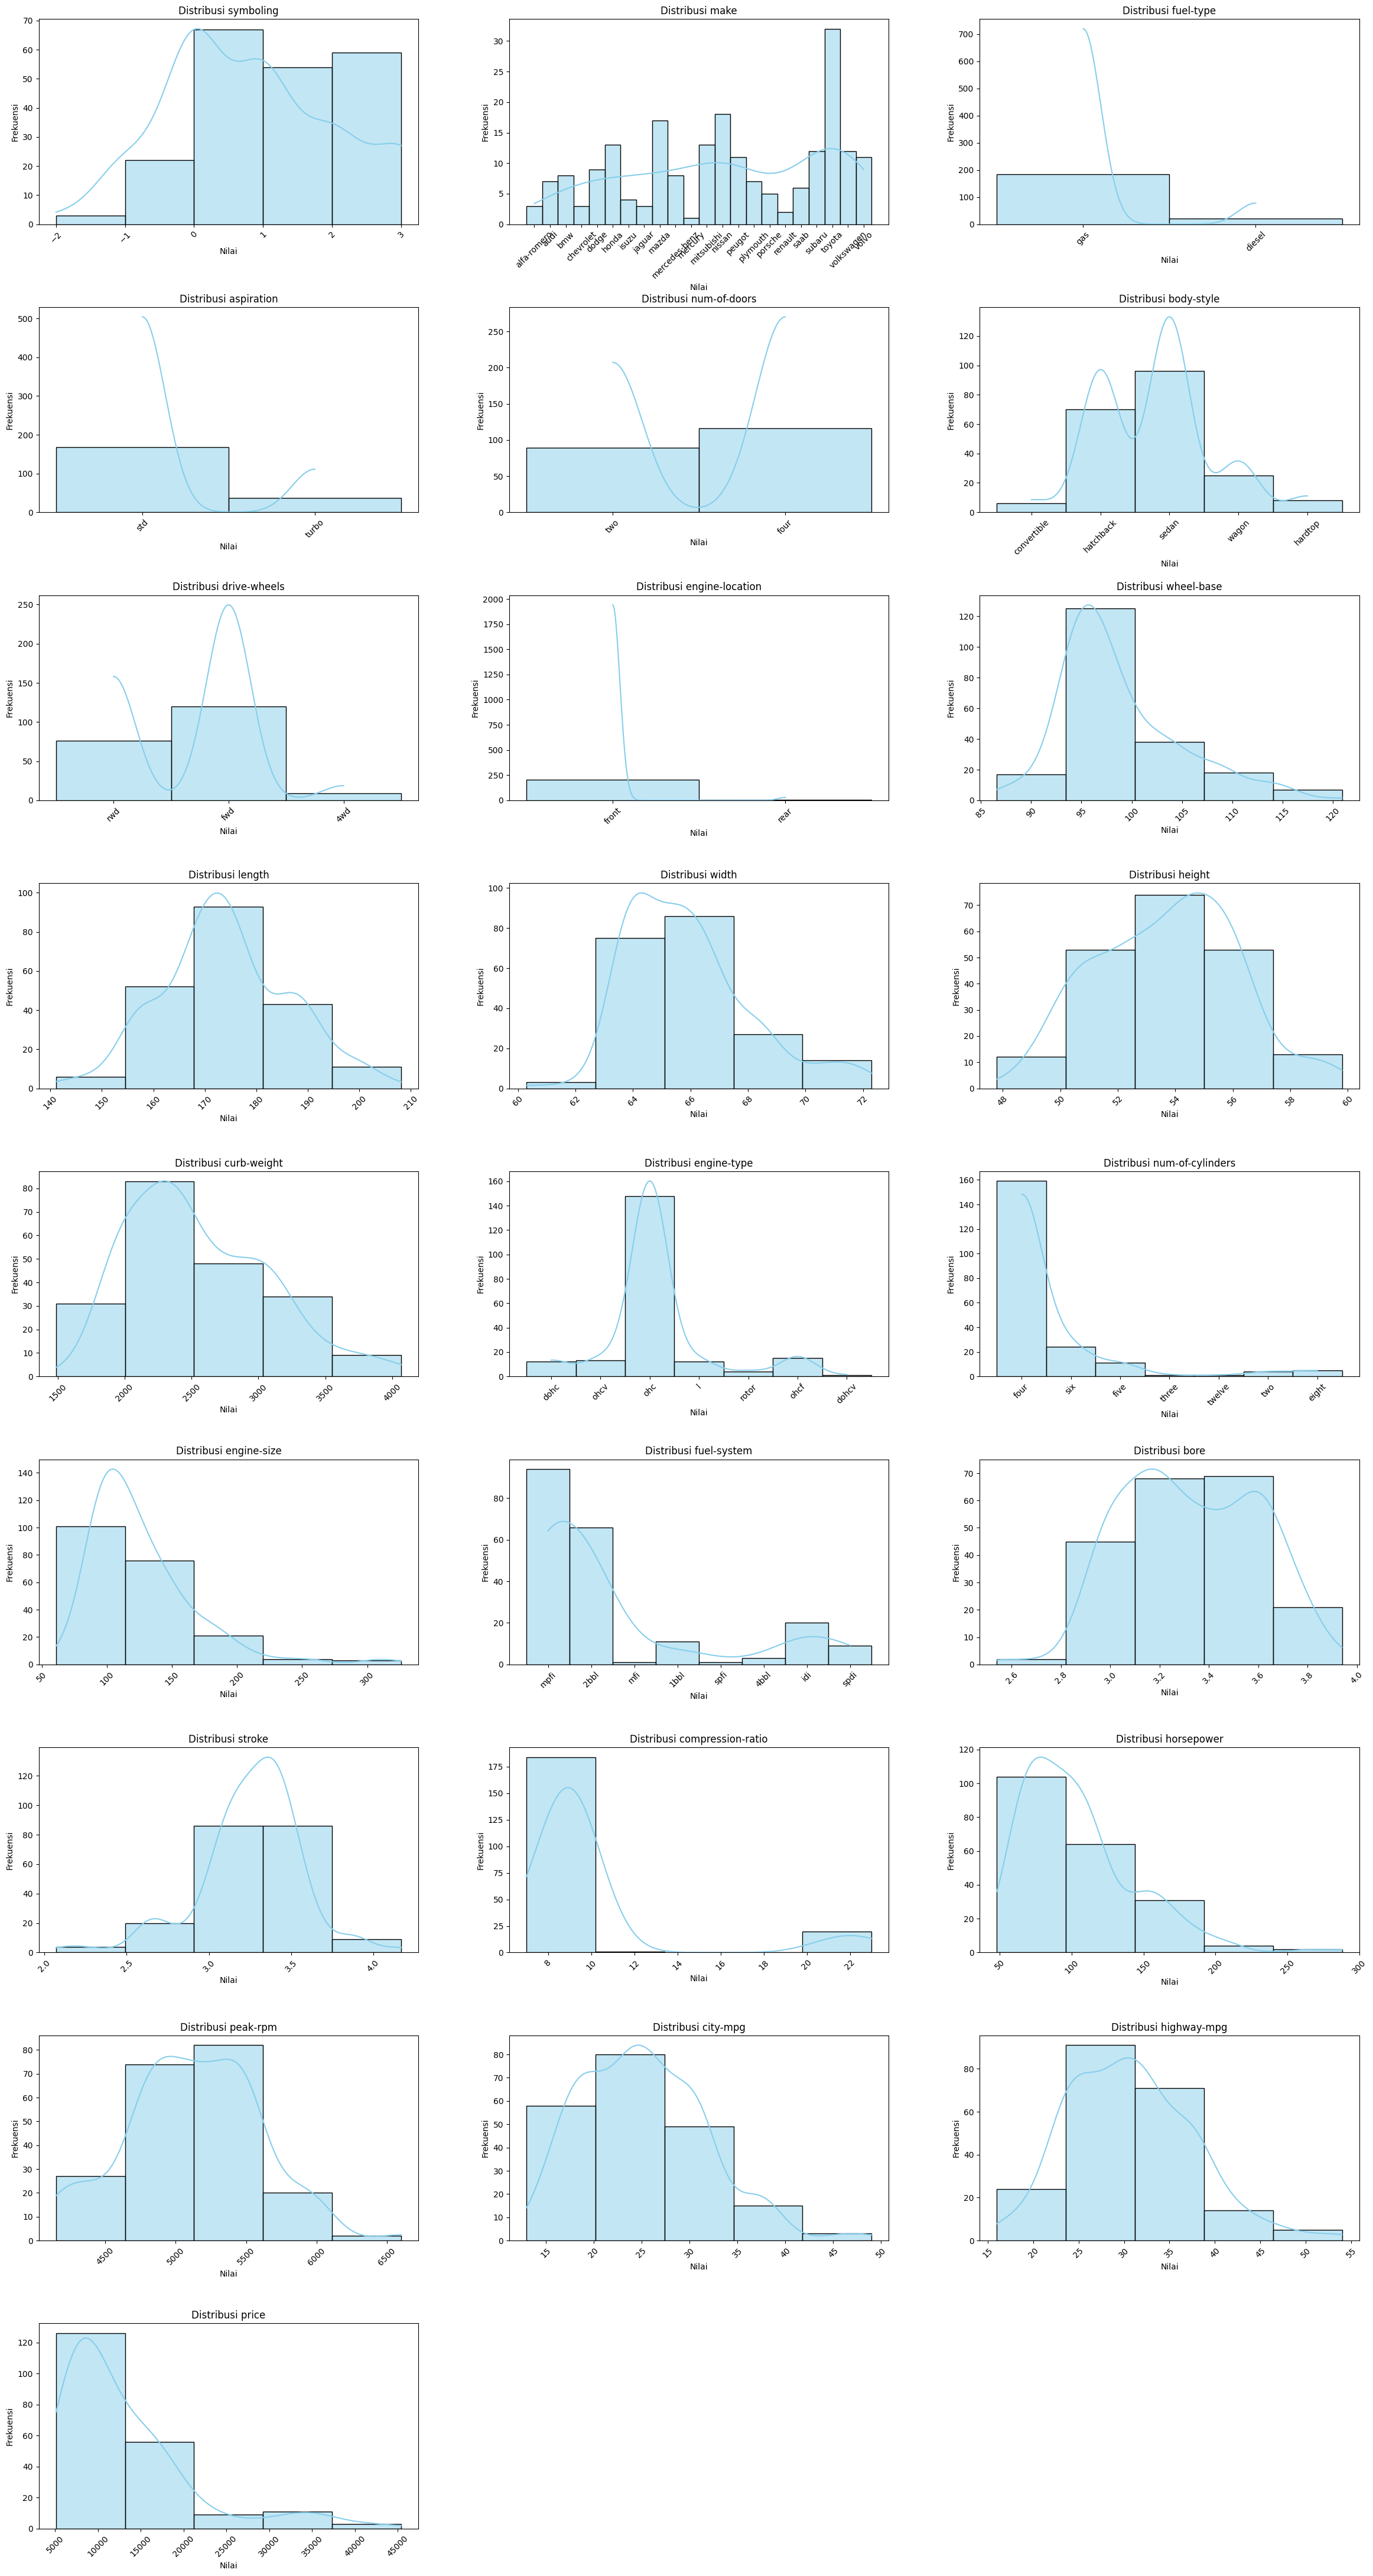

In [133]:
n_cols = 3
n_rows = (len(df.columns) // n_cols) + (1 if len(df.columns) % n_cols != 0 else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
fig.tight_layout(pad=8.0)

for i, col in enumerate(df.columns):
    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos]

    sns.histplot(df[col], bins=5, kde=True, color='skyblue', ax=ax)
    ax.set_title(f'Distribusi {col}')
    ax.set_xlabel('Nilai')
    ax.set_ylabel('Frekuensi')

    ax.tick_params(axis='x', rotation=45, labelrotation=45)

total_plots = n_cols * n_rows
for j in range(len(df.columns), total_plots):
    if n_rows == 1:
        axes[j].axis('off')
    else:
        axes.flatten()[j].axis('off')

plt.show()

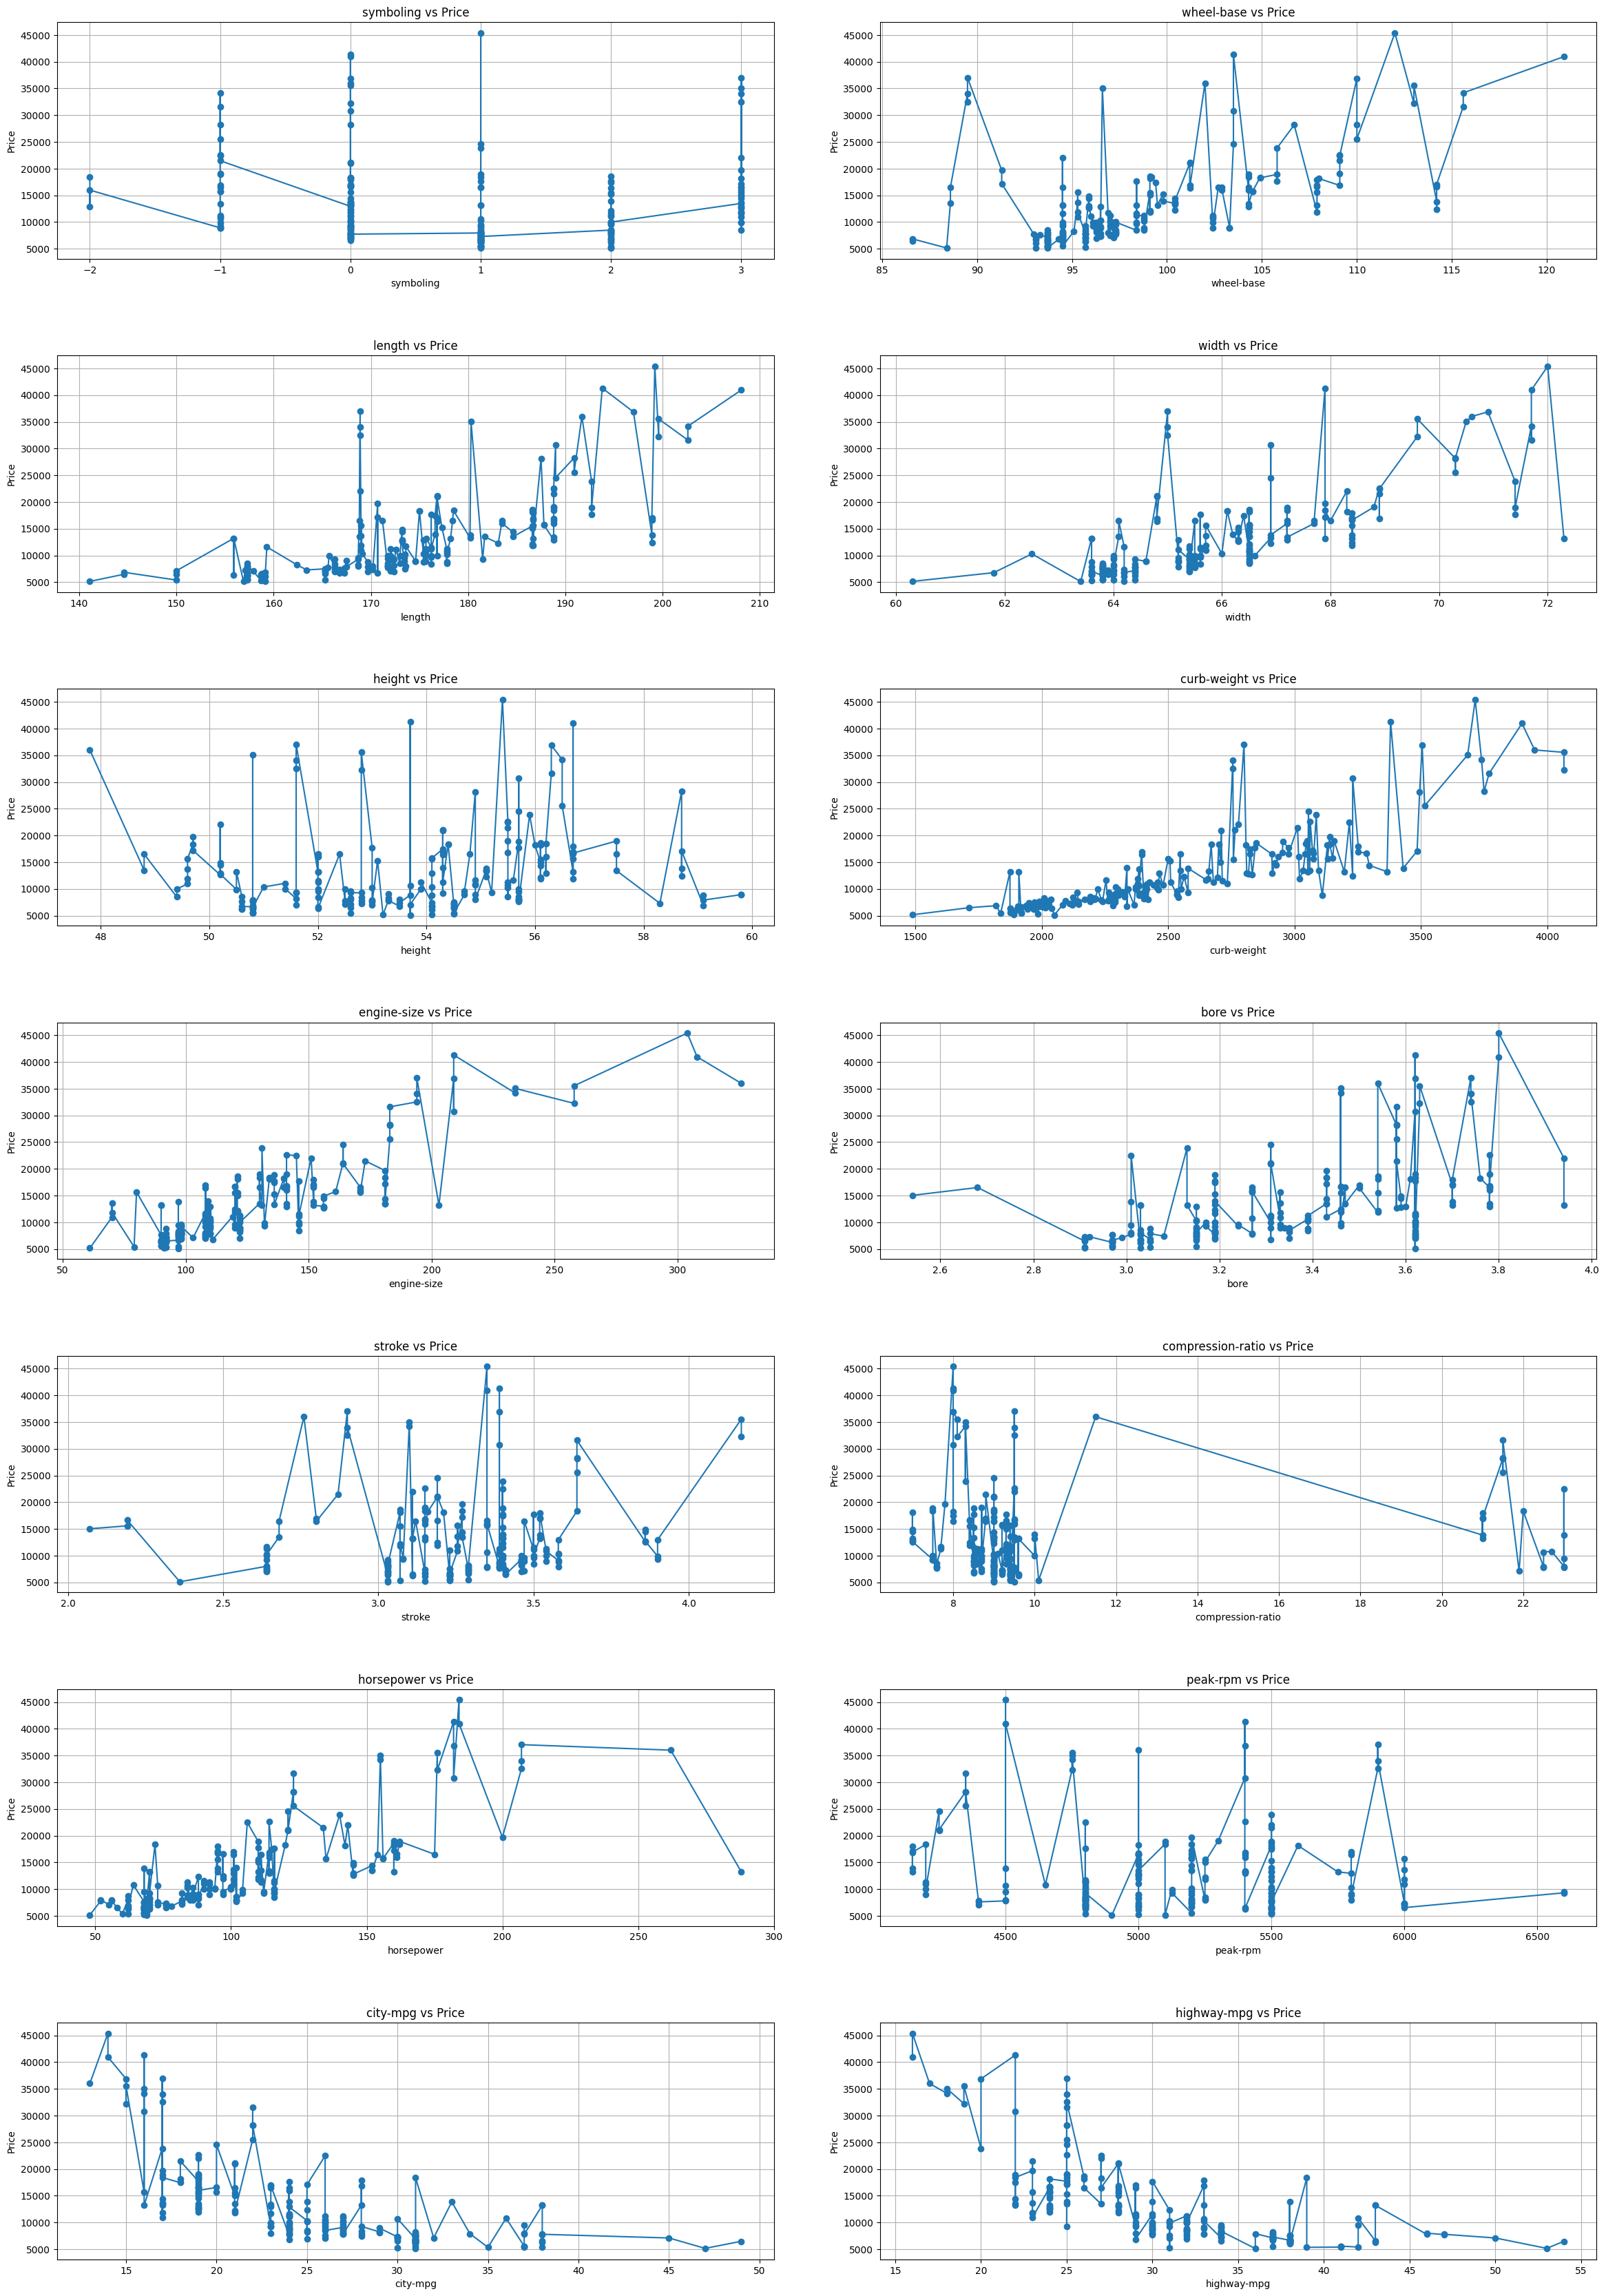

In [134]:
cols_to_plot = [col for col in data.columns if col != 'price']
n_cols = 2
n_rows = (len(cols_to_plot) // n_cols) + (1 if len(cols_to_plot) % n_cols != 0 else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
fig.tight_layout(pad=8.0)

for i, col in enumerate(cols_to_plot):
    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos] if n_rows > 1 else axes[col_pos]

    sorted_df = df.sort_values(by=col)
    ax.plot(sorted_df[col], sorted_df['price'], marker='o', linestyle='-')
    ax.set_title(f'{col} vs Price')
    ax.set_xlabel(col)
    ax.set_ylabel('Price')
    ax.grid(True)

if len(cols_to_plot) % n_cols != 0:
    for j in range(len(cols_to_plot), n_rows * n_cols):
        fig.delaxes(axes.flatten()[j])

plt.show()

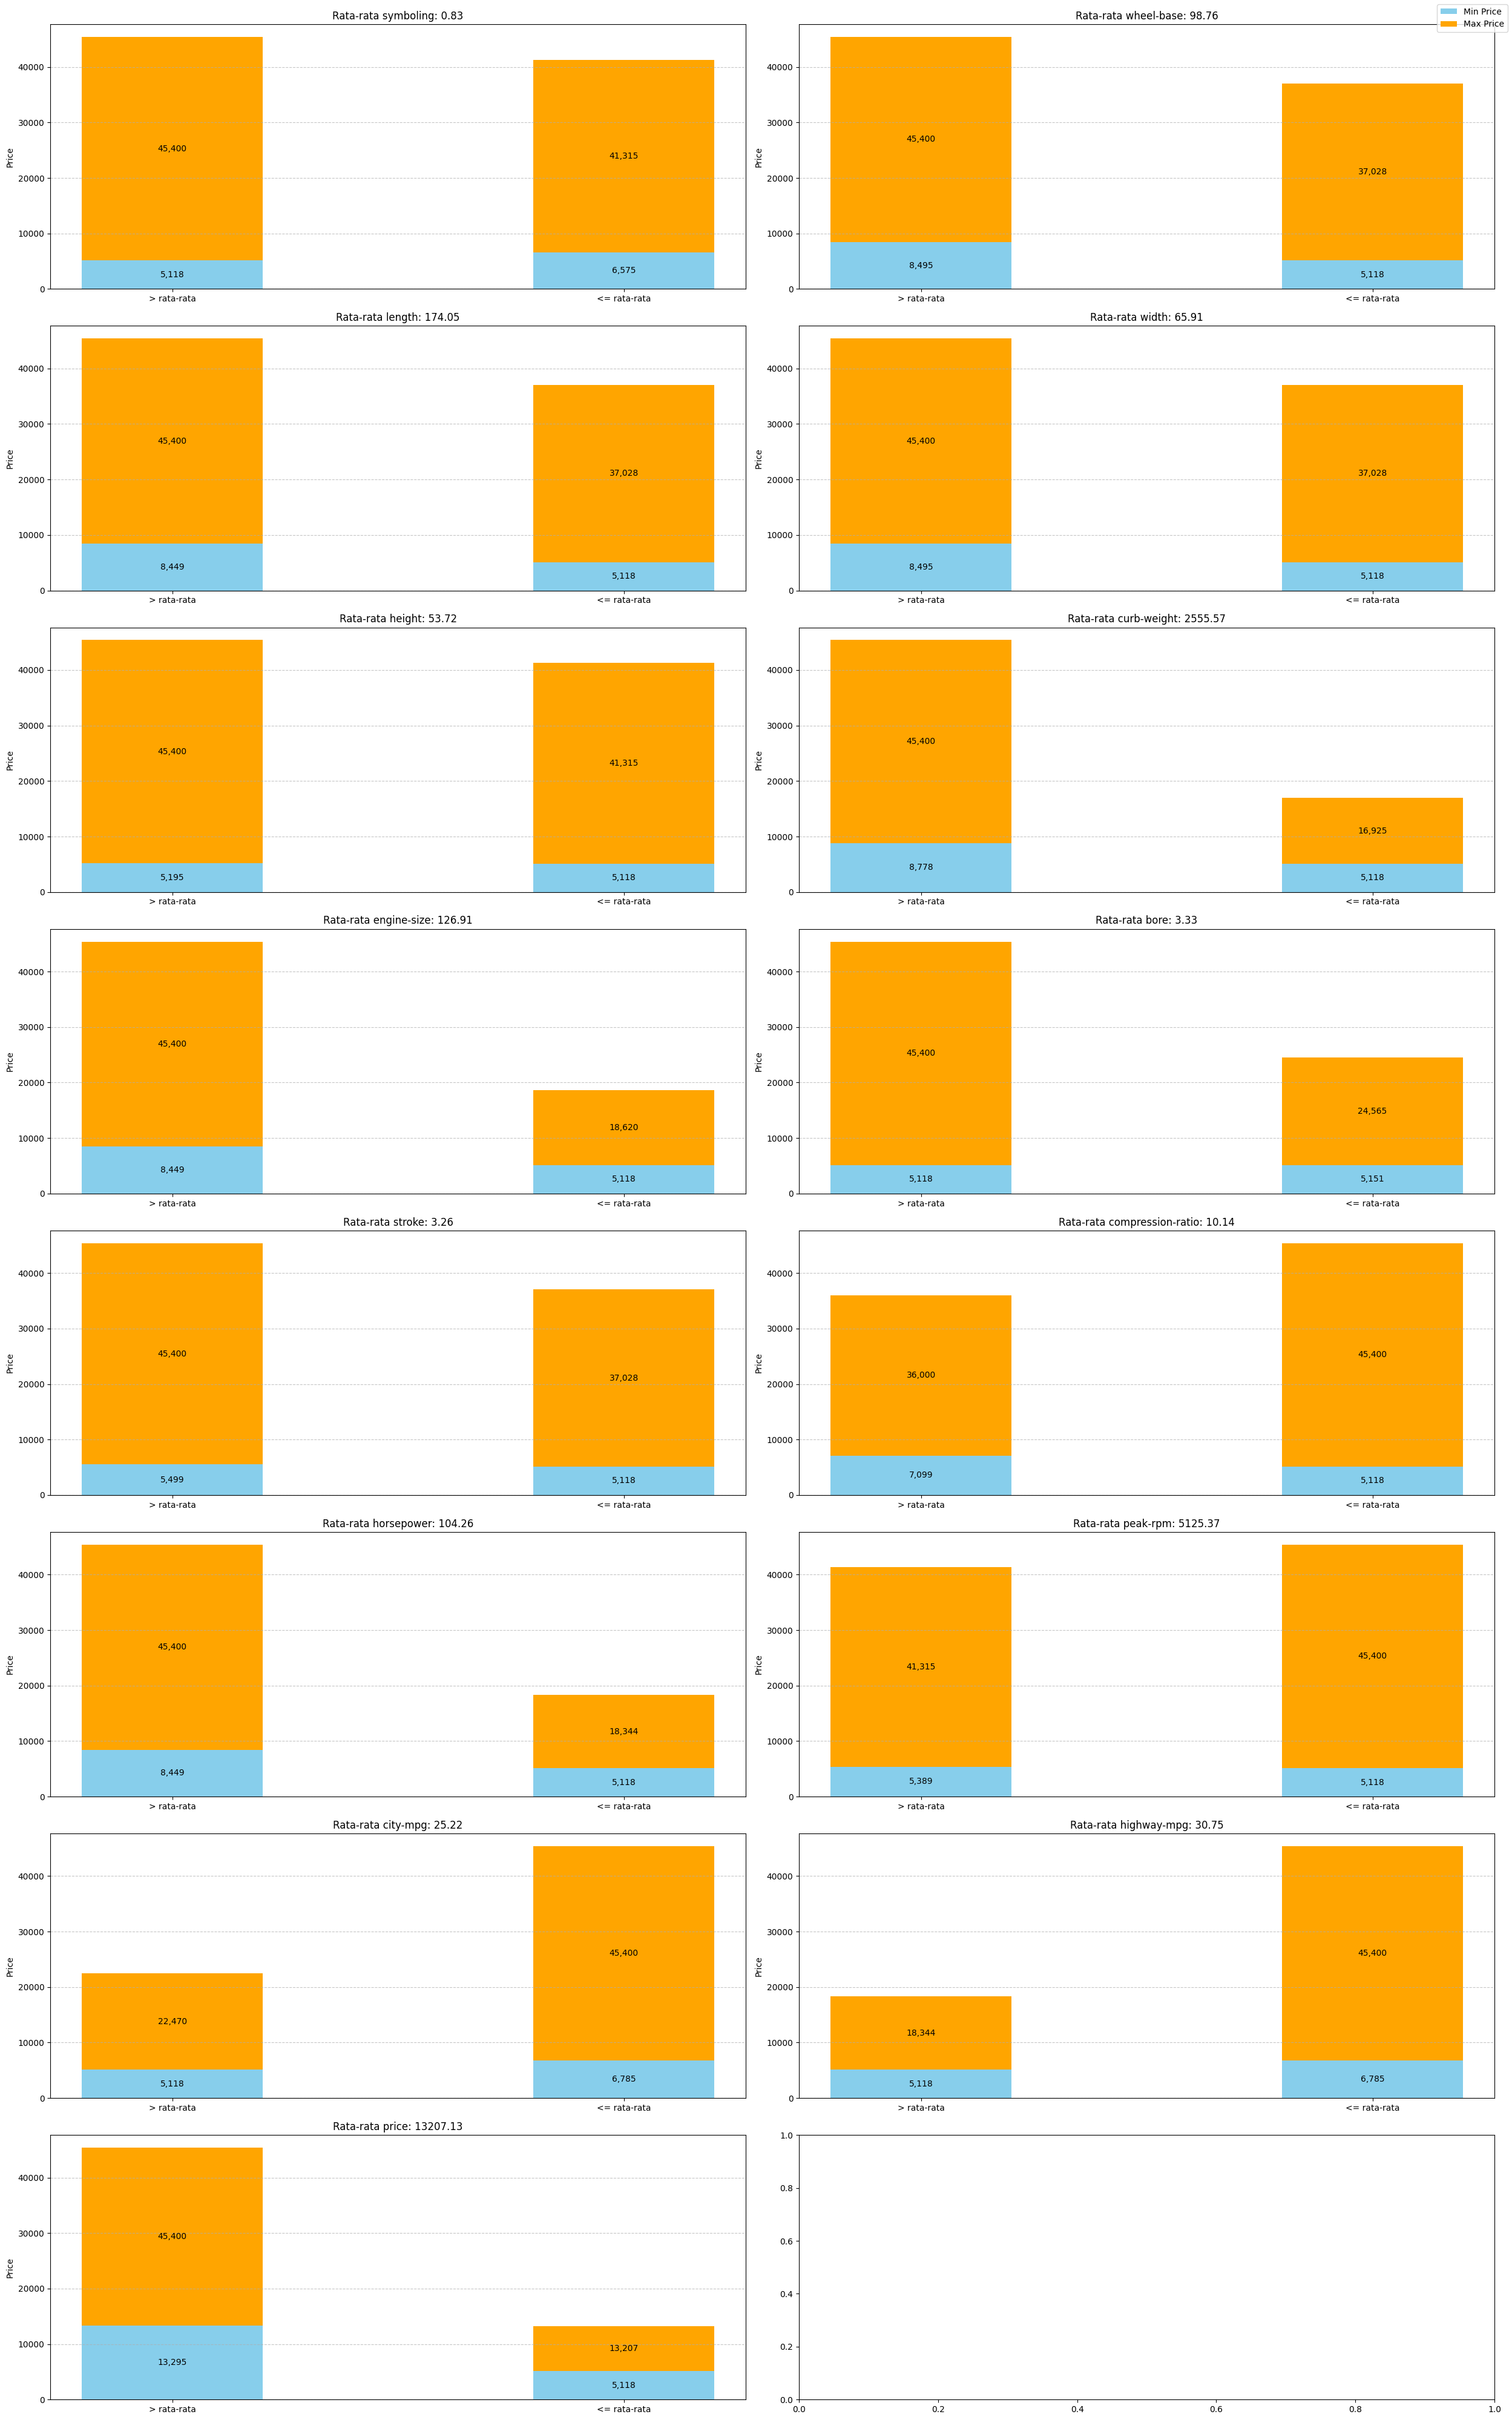

In [135]:
cols_to_plot = data.columns
n_cols = 2
n_rows = (len(cols_to_plot) // n_cols) + (1 if len(cols_to_plot) % n_cols != 0 else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
fig.tight_layout(pad=8.0)

for i, col in enumerate(cols_to_plot):
    mean_val = df[col].mean()
    above = df[df[col] > mean_val]
    below_equal = df[df[col] <= mean_val]

    min_above = above['price'].min()
    max_above = above['price'].max()
    min_below = below_equal['price'].min()
    max_below = below_equal['price'].max()

    labels = ['> rata-rata', '<= rata-rata']
    min_prices = [min_above, min_below]
    max_prices = [max_above, max_below]
    x = range(len(labels))

    row = i // n_cols
    col_pos = i % n_cols
    ax = axes[row, col_pos]

    ax.bar(x, min_prices, width=0.4, label='Min Price', color='skyblue')
    ax.bar(x, [max_prices[j] - min_prices[j] for j in x], width=0.4, label='Max Price',
           color='orange', bottom=min_prices)

    for j in x:
        ax.text(j, min_prices[j] / 2, f"{min_prices[j]:,.0f}", ha='center', va='center', color='black')
        ax.text(j, min_prices[j] + (max_prices[j] - min_prices[j]) / 2, f"{max_prices[j]:,.0f}",
                ha='center', va='center', color='black')

    ax.set_title(f'Rata-rata {col}: {mean_val:.2f}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Price')
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
plt.tight_layout()
plt.show()

<ipython-input-138-e9cd06a7a395>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=highest_prices.index, y=highest_prices.values, palette='viridis')


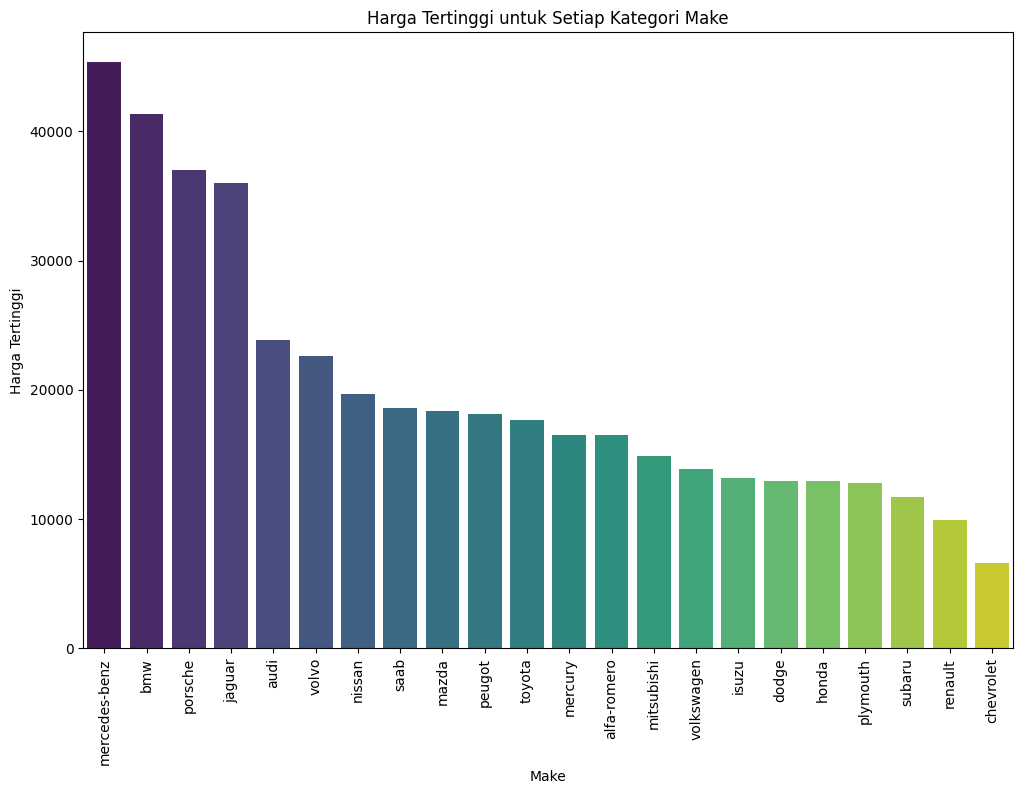

In [138]:
highest_prices = df.groupby('make')['price'].max().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=highest_prices.index, y=highest_prices.values, palette='viridis')
plt.title('Harga Tertinggi untuk Setiap Kategori Make')
plt.xlabel('Make')
plt.ylabel('Harga Tertinggi')
plt.xticks(rotation=90)
plt.show()

<ipython-input-143-3415778a85a7>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=average_prices.index, y=average_prices.values, palette='magma')


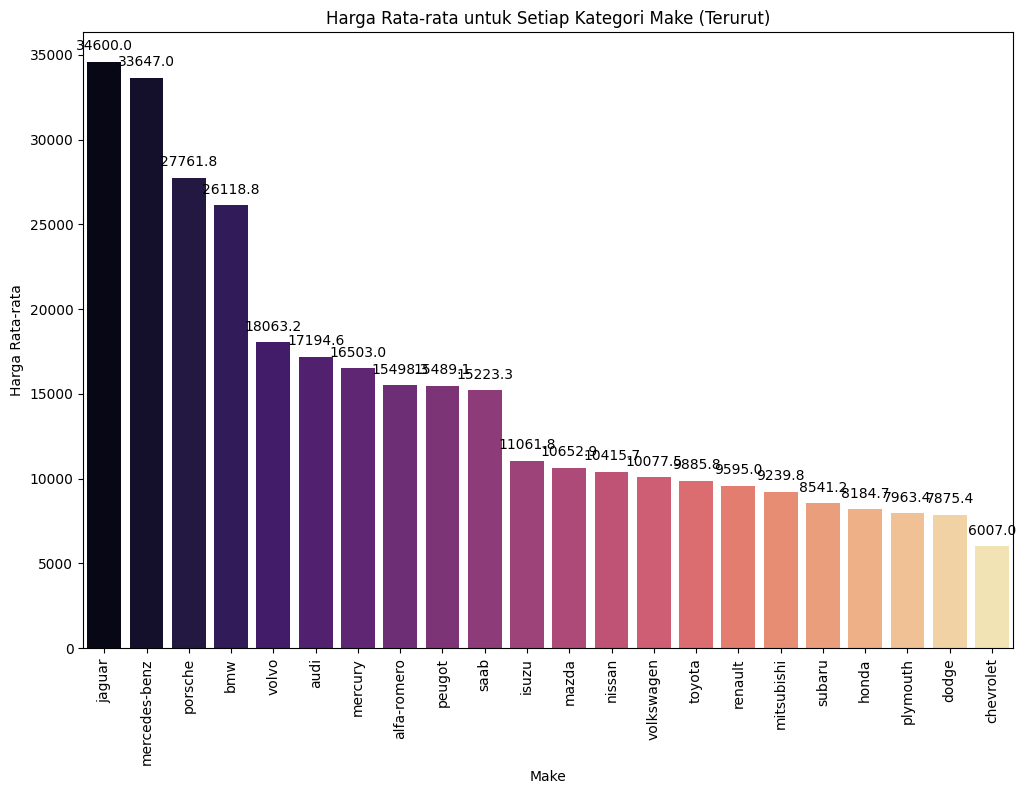

In [143]:
average_prices = df.groupby('make')['price'].mean().sort_values(ascending=False).round(1)

plt.figure(figsize=(12, 8))
ax = sns.barplot(x=average_prices.index, y=average_prices.values, palette='magma')

for i in range(len(average_prices)):
    ax.text(i, average_prices.values[i] + 500, f'{average_prices.values[i]:.1f}',
            ha='center', va='bottom', fontsize=10)

plt.title('Harga Rata-rata untuk Setiap Kategori Make (Terurut)')
plt.xlabel('Make')
plt.ylabel('Harga Rata-rata')
plt.xticks(rotation=90)
plt.show()


In [ ]:
cols_to_plot = [col for col in data.columns if col != 'price']
n_cols = 2
n_rows = (len(cols_to_plot) // n_cols) + (1 if len(cols_to_plot) % n_cols != 0 else 0)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 5 * n_rows))
fig.tight_layout(pad=8.0)

for i, col in enumerate(cols_to_plot):
    sorted_df = df.sort_values(by=col).reset_index(drop=True)

    row = i // n_cols
    col_pos = i % n_cols
    ax1 = axes[row, col_pos]

    ax1.plot(sorted_df.index, sorted_df['price'], color='blue', label='Price')
    ax1.set_xlabel('Data Index')
    ax1.set_ylabel('Price', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(sorted_df.index, sorted_df[col], color='red', label=col)
    ax2.set_ylabel(col, color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    ax1.set_title(f'Trend Comparison: Price vs {col}')
    ax1.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
correlation_matrix = data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Korelasi Antar Fitur')
plt.show()

Korelasi mununjukkan angka yang besar antara setiap fitur dengan fitur 'price'. Namun, hubungan antar fitur (diluar fitur 'price') juga tergolong seimbang (cukup s.d sangat kuat). Dengan hubungan ini akan dilakukan prediksi menggunakan ANN dengan penggunaan dropout dan regulasi jika memang learning rate menunjukkan overfitting.

Berdasarkan barplot yang ada. Kendaraan mobil didominasi oleh jenis mobil keluarga atau harian (bukan sport). Terbukti dengan dominasi dari data berikut:
1.   Tipe mobil terbanyak adalah:
  *   Pertama, sedan
  *   Kedua, hatchback
  *   Ketiga, wagon  
Menurut sumber informasi yang ada, mobil harian atau sering disebut keluarga sering hadir dalam ketiga tipe tersebut.
2.   Aspiration (tenaga pembakaran mobil) yang didominasi oleh std (standard)
3.   Jumlah pintu: 4
Selain ketiga tipe mobil sebelumnya, mobil keluarga juga didominasi oleh jumlah pintu 4 sesuai dengan fungsinya
4.   Engine size yang tidak terlalu besar berkisar di 100-150
5.   Kompresi yang cukup mendominasi di rasio 8
6.   Horse power (kekuatan mobil) yang cukup tersebar diantara 50-150
7.   City-mpg dan highway-mpg yang masih didominasi oleh angka sekitaran 15 - 35, selain itu juga terjadi cross antara kedua fitur ini dengan fitur 'price'. Hal ini juga dapat memunculkan spekulasi bahwa mobil dengan City-mpg dan highway-mpg yagn tinggi merupakan generasi mobil tua.

Ke-7 poin ini cukup untuk menarik kesimpulan bahwa mobil didominasi oleh mobil keluarga atau harian dibandingkan dengan mobil sport.



###Outliers

In [ ]:
Q1 = data[data.columns].quantile(0.25)
Q3 = data[data.columns].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

plt.figure(figsize=(16,10))
plt.title("Outliers")
for i, feature in enumerate(data.columns, 1):
  plt.subplot(6, 4, i)
  sns.boxplot(x=data[feature])
plt.tight_layout()
plt.show()

1.   Berdasarkan distribusi data yang sudah dijelaskan diatas, outliers disebabkan karena jenis mobil cenderung ke arah mobil keluarga, bukan mobil sport sehingga ciri-ciri yang dimiliki oleh mobil sport relatif sedikit.
2.   Dengan ini,ada ketidakseimbangan antara jenis mobil keluarga dengan sport. Oleh karena itu, dataset ini cocok dalam memprediksi ke arah mobil keluarga karena keterbatasan data pada jenis mobil sport.
3.   Data outliers akan dibiarkan untuk memperbanyak variasi data

###**Insight**
A. Data Quality
1.   Bagaimana jenis missing values yang ada?    
  MCAR dan MAR
2.   Bagaimana outliers-nya?
  Didominasi oleh mobil yang mengarah ke level mid-size luxury cars atau executive cars dengan harga, compression ratio, dan engine size yang semakin membesar.
3.   Bagaimana jumlah datanya dan potensi yang ada?
  Jumlah data cukup sedikit sekitar 205 data dan potensi yang ada adalah resiko dalam menangani missing value (hindari menghapus baris) dan kemungkinan generalisasi terhadap data testing yang kurang.

B. Pertanyaan Fitur "Price" (Target Label):
1.   Distribusi variabel pada setiap fitur bagaimana? dominan mengarah ke jenis mobil standard (std)
2.   Apakah terdapat outlier di fitur "price"? ya, mengarah ke harga yang semakin tinggi
3.   Bagaimana korelasi setiap fitur terhadap fitur "price"? Terdapat hubungan antar fitur >= 0.7 (negatif/positif) yang menunjukkan kekuatan hubungan moderat s.d sangat kuat

Representasi korelasi:
*   **0.9 ≤	r	≤ 1.0**	Korelasi sangat kuat
*   **0.7 ≤	r	< 0.9**	Korelasi kuat
*   **0.5 ≤	r	< 0.7**	Korelasi moderat (cukup kuat)
*   **0.3 ≤	r	< 0.5**	Korelasi lemah
*   **0.0 ≤	r	< 0.3**	Korelasi sangat lemah/tidak ada

C. Pertanyaan Fitur Numerik:
1.   Ada multikolinearitas antara fitur numerik? Berdasarkan korelasi setiap fitur, ada potensi ke arah multikolinearitas seperti fitur wheel base, lenght, width, curb weight, engine size, horse power, city mpg, highway mpg, price


D. Pertanyaan Tentang Fitur Kategorikal
1.   Tipe mobil apa (SUV, sedan, dll) yang punya harga tertinggi? [1] mercedes-benz, [2] bmw, dan [3] porsche
2.   Bagaimana rata-rata dari setiap merk mobil? Jaguar menempati posisi rata-rata kendaraan tertinggi, disusul oleh mercedes benz, lalu porsche dan bmw. Merk lain memiliki perbedaan harga yang cukup jauh dari keempat kendaraan sebelumnya namun memiliki nilai yang tidak terlalu jauh diantaranya.
3.   Bagaimana pengaruh num of doors, body style, engine size, dan compression ratio ke harga? Memiliki pengaruh cukup kuat terhadap harga sehingga ini menjadi fitur penting dan saling berpengaruh.




#Preprocessing

In [144]:
one_hot_cols = ['fuel-type', 'aspiration', 'num-of-doors', 'drive-wheels', 'engine-location']
binary_cols = ['make', 'body-style', 'engine-type', 'num-of-cylinders', 'fuel-system']

binary_label_map = {col: df[col].copy() for col in binary_cols}

one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
one_hot_encoded = pd.DataFrame(
    one_hot_encoder.fit_transform(df[one_hot_cols]),
    columns=one_hot_encoder.get_feature_names_out(one_hot_cols)
)

binary_encoder = ce.BinaryEncoder(cols=binary_cols)
binary_encoded = binary_encoder.fit_transform(df[binary_cols])

df_encoded = pd.concat([
    df.drop(columns=one_hot_cols + binary_cols),
    one_hot_encoded,
    binary_encoded
], axis=1)

scaler = StandardScaler()
scaled_data = pd.DataFrame(
    scaler.fit_transform(df_encoded),
    columns=df_encoded.columns
)

scaled_data.head()

,symboling,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price,fuel-type_gas,aspiration_turbo,num-of-doors_two,drive-wheels_fwd,drive-wheels_rwd,engine-location_rear,make_0,make_1,make_2,make_3,make_4,body-style_0,body-style_1,body-style_2,engine-type_0,engine-type_1,engine-type_2,num-of-cylinders_0,num-of-cylinders_1,num-of-cylinders_2,fuel-system_0,fuel-system_1,fuel-system_2,fuel-system_3
0,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519089,-1.839404,-0.288349,0.171065,-0.263484,-0.646553,-0.546059,0.036674,0.328798,-0.469295,1.141653,-1.188177,1.302831,-0.121867,-0.8,-0.783692,-1.359126,-0.867258,1.097407,-0.438019,-2.063107,0.929320,-0.430083,-2.514245,0.492366,-0.23812,-0.522773,0.405922,-0.214286,-0.453743,-0.884652,0.875923
1,1.743470,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519089,-1.839404,-0.288349,0.171065,-0.263484,-0.646553,-0.546059,0.419498,0.328798,-0.469295,1.141653,-1.188177,1.302831,-0.121867,-0.8,-0.783692,-1.359126,-0.867258,1.097407,-0.438019,-2.063107,0.929320,-0.430083,-2.514245,0.492366,-0.23812,-0.522773,0.405922,-0.214286,-0.453743,-0.884652,0.875923
2,0.133509,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,0.604046,-2.404862,0.685920,-0.288349,1.261807,-0.263484,-0.953012,-0.691627,0.419498,0.328798,-0.469295,1.141653,-1.188177,1.302831,-0.121867,-0.8,-0.783692,-1.359126,-0.867258,1.097407,-0.438019,0.484706,-1.076055,-0.430083,0.397734,-2.031010,-0.23812,1.912875,-2.463527,-0.214286,-0.453743,-0.884652,0.875923
3,0.938490,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.431076,-0.517248,0.462157,-0.035973,-0.057230,0.787346,-0.186865,-0.109354,0.094639,0.328798,-0.469295,-0.875923,0.841625,-0.767559,-0.121867,-0.8,-0.783692,-1.359126,1.153059,-0.911239,-0.438019,0.484706,0.929320,-0.430083,0.397734,0.492366,-0.23812,-0.522773,0.405922,-0.214286,-0.453743,-0.884652,0.875923
4,0.938490,0.107110,0.207256,0.230001,0.235942,0.516807,0.218885,-0.517248,0.462157,-0.540725,0.272529,0.787346,-1.106241,-1.273900,0.540524,0.328798,-0.469295,-0.875923,-1.188177,-0.767559,-0.121867,-0.8,-0.783692,-1.359126,1.153059,-0.911239,-0.438019,0.484706,0.929320,-0.430083,0.397734,0.492366,-0.23812,1.912875,0.405922,-0.214286,-0.453743,-0.884652,0.875923


#Training Model

In [145]:
X = scaled_data.drop('price', axis=1)
y = scaled_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

def lr_schedule(epoch, lr):
    return 0.001

lr_history = []
class LearningRateLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy()
        lr_history.append(lr)

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[LearningRateScheduler(lr_schedule), LearningRateLogger()],
    verbose=0
)

y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2%}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
R² Score: 0.8881
MAE: 0.27
MSE: 0.14
RMSE: 0.38
MAPE: 16486311841612404.00%
